<a href="https://colab.research.google.com/github/rshar95/BayesianInference/blob/main/Gibbs_Sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
%pip install harmonic emcee corner getdist

In [3]:
%%capture
# Google Colaboratory-specific: clone useful utils module from harmonic repo
!git clone https://github.com/astro-informatics/harmonic.git
import sys
sys.path.append("harmonic/examples")

In [4]:
%matplotlib inline
from IPython.display import YouTubeVideo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import norm, gamma, uniform
import pymc3 as pm3
from scipy import optimize
import corner as corner
import emcee as emcee

import warnings
warnings.filterwarnings('ignore')

sbn.set_style('white')
sbn.set_context('talk')

np.random.seed(12578)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


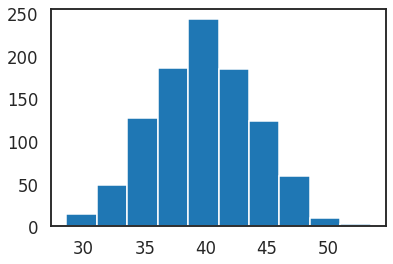

In [5]:
N = 1000
Y = norm(40,4).rvs(N)
plt.hist(Y);

In [22]:
df = pd.read_csv('reg_feat_scaled.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.0,0.616428,0.381954,0.412604,0.629672,0.327458,0.506746,0.905759,0.545684,0.386354,...,0.000000,0.0,0.000000,0.042438,0.0,0.0,0.251926,0.064619,0.0,0.0
1,1.0,0.570472,0.581774,0.616976,0.522112,0.446988,0.582008,0.910995,0.545684,0.386354,...,0.000580,0.0,0.000000,0.042438,0.0,0.0,0.361503,0.059885,0.0,0.0
2,1.0,0.603199,0.518259,0.493833,0.477432,0.597634,0.486630,0.916230,0.545684,0.386354,...,0.000575,0.0,0.000000,0.042438,0.0,0.0,0.361503,0.046147,0.0,0.0
3,1.0,0.613092,0.588907,0.601717,0.631732,0.600613,0.503062,0.916230,0.545684,0.386354,...,0.000706,0.0,0.000000,0.042438,0.0,0.0,0.361503,0.078478,0.0,0.0
4,1.0,0.513113,0.635965,0.710973,0.629430,0.651308,0.626787,0.910995,0.545684,0.386354,...,0.000725,0.0,0.053291,0.212652,0.0,0.0,0.000000,0.083062,0.0,0.0


In [39]:
Y1,Y2,Y3,Y4 = np.loadtxt("reg_feat_scaled.csv", delimiter=',', usecols=(2, 5,7,8), unpack=True)


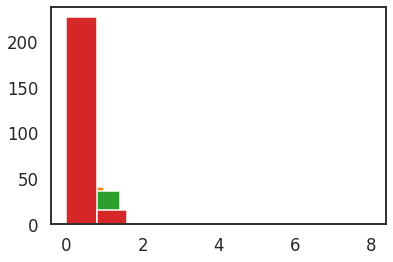

In [59]:
plt.hist(Y1);
plt.hist(Y2);
plt.hist(Y3);
plt.hist(Y4);

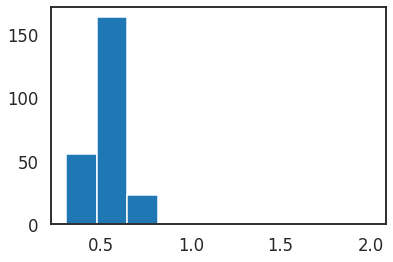

In [60]:
plt.hist(Y1);


In [50]:
chain_len = 10000
burnin = 1000

In [52]:
#storing chains here
mu_chain_gibbs =np.zeros((chain_len+burnin,1)) 
sigma_chain_gibbs = np.zeros(mu_chain_gibbs.shape)

# starting guesses for mu
mu_old = 40

for i in np.arange(chain_len+burnin):
    gamma_new = gamma(len(Y1)/2,scale=1/np.sum(((Y1-mu_old)**2)/2)).rvs()
    var_new = 1/gamma_new
    mu_new = norm(np.mean(Y1), np.sqrt(var_new/len(Y1))).rvs(1)
    mu_chain_gibbs[i] = mu_new
    sigma_chain_gibbs[i] = np.sqrt(var_new)
    # reset old values
    mu_old,var_old = mu_new,var_new

In [53]:
chain_gibbs = pd.DataFrame(np.append(mu_chain_gibbs,sigma_chain_gibbs,1),columns=['mean','std'])
# calculate summary statistics post burn-in
chain_gibbs.loc[burnin:].describe(percentiles=[.025,.5,.975])


,mean,std
count,10000.000000,10000.000000
mean,0.545249,0.122395
std,0.007791,0.005569
min,0.514615,0.103982
2.5%,0.529868,0.112078
50%,0.545271,0.122213
97.5%,0.560558,0.133888
max,0.576451,0.150589


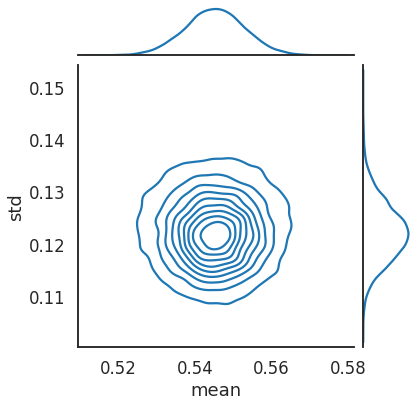

In [54]:
plot_gibbs = chain_gibbs.loc[burnin:]
plot_gibbs.head()
sbn.jointplot(x='mean', y='std', data=plot_gibbs, kind="kde")

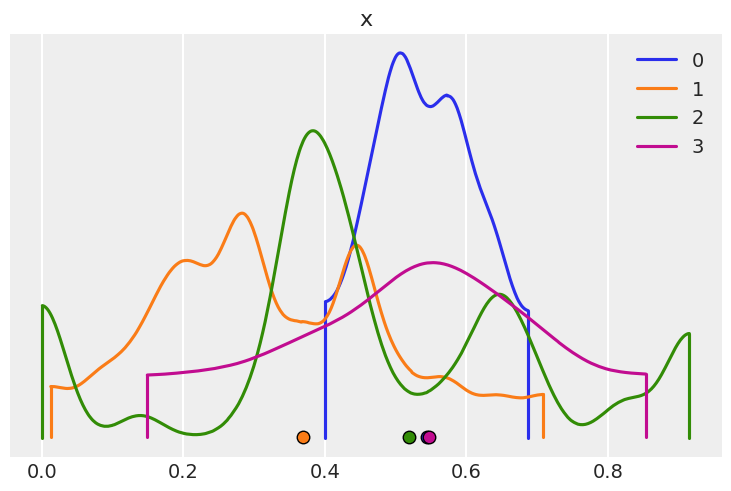

In [121]:
az.plot_density(
    [Y1,Y2,Y3,Y4],
    group="sample_stats",
    point_estimate="mean"
);

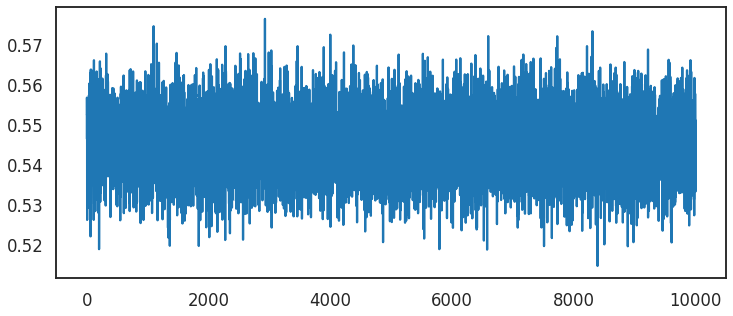

In [61]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(chain_len),plot_gibbs['mean'])
plt.show()

In [69]:
import arviz as az
import theano
import xarray
import pymc3 as pm



In [70]:
az.style.use("arviz-darkgrid")


In [124]:
n_ = theano.shared(np.asarray([10, 15]))

In [125]:
with pm.Model() as m:
    p = pm.Beta("p", 1.0, 1.0)
    ni = pm.Bernoulli("ni", 0.5)
    k = pm.Binomial("k", p=p, n=n_[ni], observed=4)
    trace = pm.sample(10000, return_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [p]
>BinaryGibbsMetropolis: [ni]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.


In [126]:
m.free_RVs


[p_logodds__ ~ TransformedDistribution, ni ~ Bernoulli]

In [127]:
with m:
    step1 = pm.Metropolis([p])
    step2 = pm.BinaryMetropolis([ni])
    trace = pm.sample(
        10000,
        return_inferencedata=True,
        step=[step1, step2],
        idata_kwargs={
            "dims": {"accept": ["step"]},
            "coords": {"step": ["Metropolis", "BinaryMetropolis"]},
        },
    )

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p]
>BinaryMetropolis: [ni]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [128]:
point = m.test_point
point

{'p_logodds__': array(0.), 'ni': array(0)}

In [129]:
point, state = step1.step(point=point)
point, state

({'p_logodds__': array(-1.18537649), 'ni': array(0)},
 [{'tune': False,
   'scaling': array([1.]),
   'accept': 0.44514531564768894,
   'accepted': True}])

In [130]:
point = step2.step(point=point)
point

({'p_logodds__': array(-1.18537649), 'ni': array(0)},
 [{'tune': False, 'accept': 1.0, 'p_jump': 0.5}])

In [131]:
with m:
    comp_step1 = pm.CompoundStep([step1, step2])
    trace1 = pm.sample(10000, comp_step1, return_inferencedata=True)
comp_step1.methods

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p]
>BinaryMetropolis: [ni]


Sampling 2 chains for 0 tune and 11_000 draw iterations (0 + 22_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [132]:
# These are the Sample Stats for Compound Step based sampling
list(trace1.sample_stats.data_vars)

['p_jump', 'scaling', 'accepted', 'accept']

In [133]:
trace1.sample_stats["accept"].sel(chain=1).values


array([[3.10180404e-03, 2.03125000e-01],
       [1.58458008e-01, 1.00000000e+00],
       [3.94674866e-02, 1.00000000e+00],
       ...,
       [1.38578994e-01, 1.72392200e-02],
       [4.91297251e+00, 1.29554868e-01],
       [6.84872375e-02, 1.29554868e-01]])

In [136]:
with m:
    comp_step2 = pm.CompoundStep([step2, step1])
    trace1 = pm.sample(10000, comp_step2, return_inferencedata=True)
comp_step2.methods

Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryMetropolis: [ni]
>Metropolis: [p]


Sampling 2 chains for 0 tune and 11_000 draw iterations (0 + 22_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


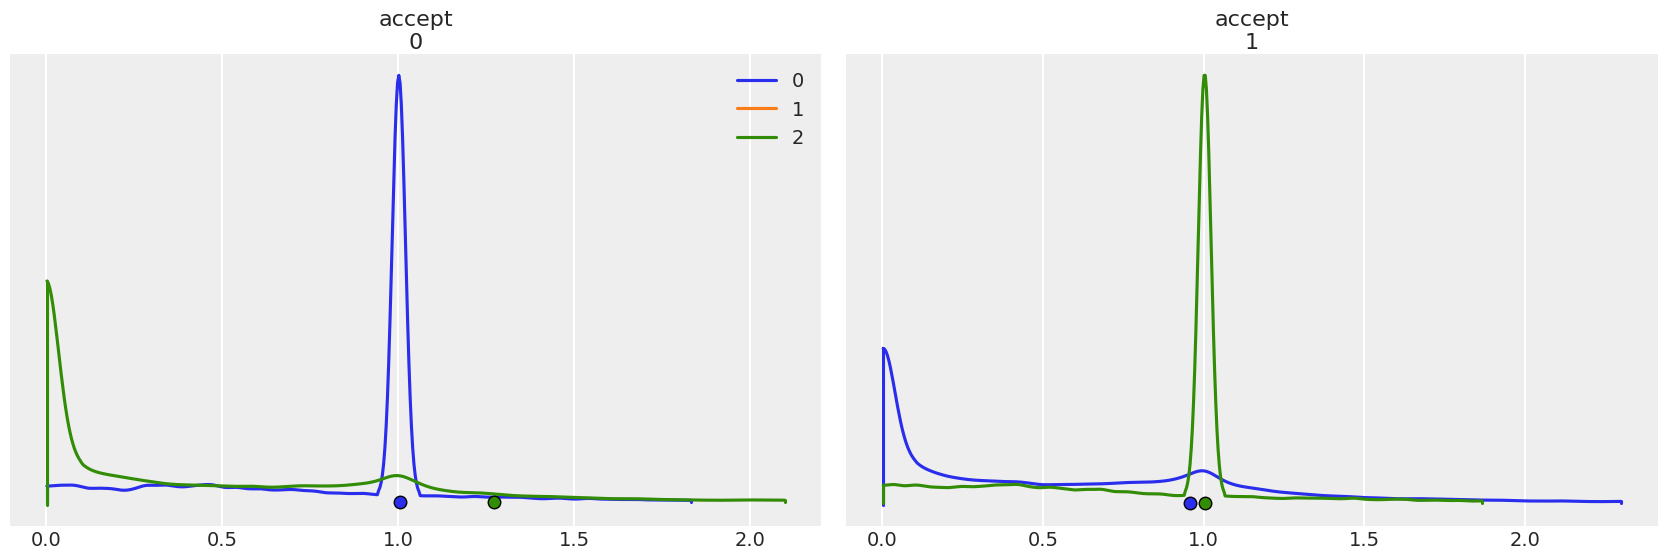

In [138]:
az.plot_density(
    [trace1,trace2,trace],
    group="sample_stats",
    var_names="accept",
    point_estimate="mean",
);